In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           balanced_accuracy_score, f1_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
import joblib

# Advanced ML libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available. Install with: pip install lightgbm")

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
print(f"SHAP available: {SHAP_AVAILABLE}")

SHAP not available. Install with: pip install shap
Libraries imported successfully!
XGBoost available: True
LightGBM available: True
SHAP available: False


In [2]:
# Load preprocessed datasets
print("LOADING PREPROCESSED DATA")

try:
    # Load preprocessed datasets
    X_train = pd.read_csv('X_train_scaled.csv')
    X_val = pd.read_csv('X_val_scaled.csv')
    X_test = pd.read_csv('X_test_scaled.csv')
    
    y_train = pd.read_csv('y_train.csv').squeeze()
    y_val = pd.read_csv('y_val.csv').squeeze()
    y_test = pd.read_csv('y_test.csv').squeeze()
    ### The .squeeze() method removes dimensions of size 1, converting a DataFrame to a Series
    ### The .squeeze() method is a clean, robust way to ensure your target variables are in the correct 1D format that sklearn expects, 
    ### preventing potential errors during model training and evaluation.
    
    # Load preprocessing objects
    scaler = joblib.load('scaler.pkl')
    selected_features = joblib.load('selected_features.pkl')
    
    print("...Preprocessed data loaded successfully!!....")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Display class distribution
    print("\nClass distribution:")
    print("Training set:")
    print(y_train.value_counts().sort_index())
    print("\nValidation set:")
    print(y_val.value_counts().sort_index())
    print("\nTest set:")
    print(y_test.value_counts().sort_index())
    
    # Display selected features
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")
        
except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please run the preprocessing notebook first to generate the required files.")
    print("Required files: X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
    print("                y_train.csv, y_val.csv, y_test.csv")
    print("                scaler.pkl, selected_features.pkl")


LOADING PREPROCESSED DATA
...Preprocessed data loaded successfully!!....
Training set: (15288, 25)
Validation set: (5096, 25)
Test set: (5096, 25)

Class distribution:
Training set:
case_status
0     5077
1    10211
Name: count, dtype: int64

Validation set:
case_status
0    1693
1    3403
Name: count, dtype: int64

Test set:
case_status
0    1692
1    3404
Name: count, dtype: int64

Selected features (25):
 1. has_job_experience
 2. continent_Africa
 3. continent_Asia
 4. continent_Europe
 5. continent_North America
 6. continent_South America
 7. education_of_employee_Bachelor'S
 8. education_of_employee_Doctorate
 9. education_of_employee_High School
10. education_of_employee_Master'S
11. region_of_employment_Island
12. region_of_employment_Midwest
13. region_of_employment_Northeast
14. region_of_employment_South
15. region_of_employment_West
16. unit_of_wage_Hour
17. unit_of_wage_Year
18. no_of_employees
19. yr_of_estab
20. prevailing_wage
21. no_of_employees_log
22. yr_of_estab_lo

step 2. Baseline Model - Logistic Regression**


In [4]:
# Baseline Logistic Regression model
print("BASELINE LOGISTIC REGRESSION MODEL")
print("EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction")

# Create and train baseline model
baseline_model = LogisticRegression(
    random_state=234,
    max_iter=100,
    class_weight='balanced'  # Handle class imbalance as recommended by EDA
)

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions
y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)
y_test_pred = baseline_model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
val_balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
val_f1 = f1_score(y_val, y_val_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\nBaseline Model Performance:")
print(f"Training - Accuracy: {train_accuracy:.3f}, Balanced Acc: {train_balanced_acc:.3f}, Macro F1: {train_f1:.3f}")
print(f"Validation - Accuracy: {val_accuracy:.3f}, Balanced Acc: {val_balanced_acc:.3f}, Macro F1: {val_f1:.3f}")
print(f"Test - Accuracy: {test_accuracy:.3f}, Balanced Acc: {test_balanced_acc:.3f}, Macro F1: {test_f1:.3f}")

# Display feature coefficients (interpretability)
print(f"\nFeature Coefficients (Top 10):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:.3f}")

# Store baseline results
baseline_results = {
    'model': 'Logistic Regression',
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_acc': train_balanced_acc,
    'val_balanced_acc': val_balanced_acc,
    'test_balanced_acc': test_balanced_acc,
    'train_f1': train_f1,
    'val_f1': val_f1,
    'test_f1': test_f1
}

print(".... Baseline model completed!")


BASELINE LOGISTIC REGRESSION MODEL
EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction

Baseline Model Performance:
Training - Accuracy: 0.714, Balanced Acc: 0.704, Macro F1: 0.692
Validation - Accuracy: 0.710, Balanced Acc: 0.698, Macro F1: 0.687
Test - Accuracy: 0.695, Balanced Acc: 0.681, Macro F1: 0.671

Feature Coefficients (Top 10):
 1. education_of_employee_High School: -0.568
 2. has_job_experience: 0.497
 3. education_of_employee_Master'S: 0.317
 4. unit_of_wage_Hour: -0.315
 5. education_of_employee_Doctorate: 0.311
 6. continent_Europe: 0.280
 7. region_of_employment_Midwest: 0.202
 8. region_of_employment_West: -0.152
 9. unit_of_wage_Year: 0.118
10. education_of_employee_Bachelor'S: -0.096
.... Baseline model completed!


Step 3. Random Forest Classifier (VERY IMPORTANT EDA Recommendation)

RANDOM FOREST CLASSIFIER
EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers

Random Forest Performance:
Training - Accuracy: 0.730, Balanced Acc: 0.697, Macro F1: 0.696
Validation - Accuracy: 0.726, Balanced Acc: 0.689, Macro F1: 0.690
Test - Accuracy: 0.713, Balanced Acc: 0.677, Macro F1: 0.677

Feature Importance (Top 10):
 1. education_of_employee_High School: 0.254
 2. education_of_employee_Master'S: 0.139
 3. has_job_experience: 0.131
 4. unit_of_wage_Hour: 0.086
 5. prevailing_wage_log: 0.062
 6. education_of_employee_Doctorate: 0.062
 7. prevailing_wage: 0.053
 8. education_of_employee_Bachelor'S: 0.046
 9. continent_Europe: 0.039
10. unit_of_wage_Year: 0.034


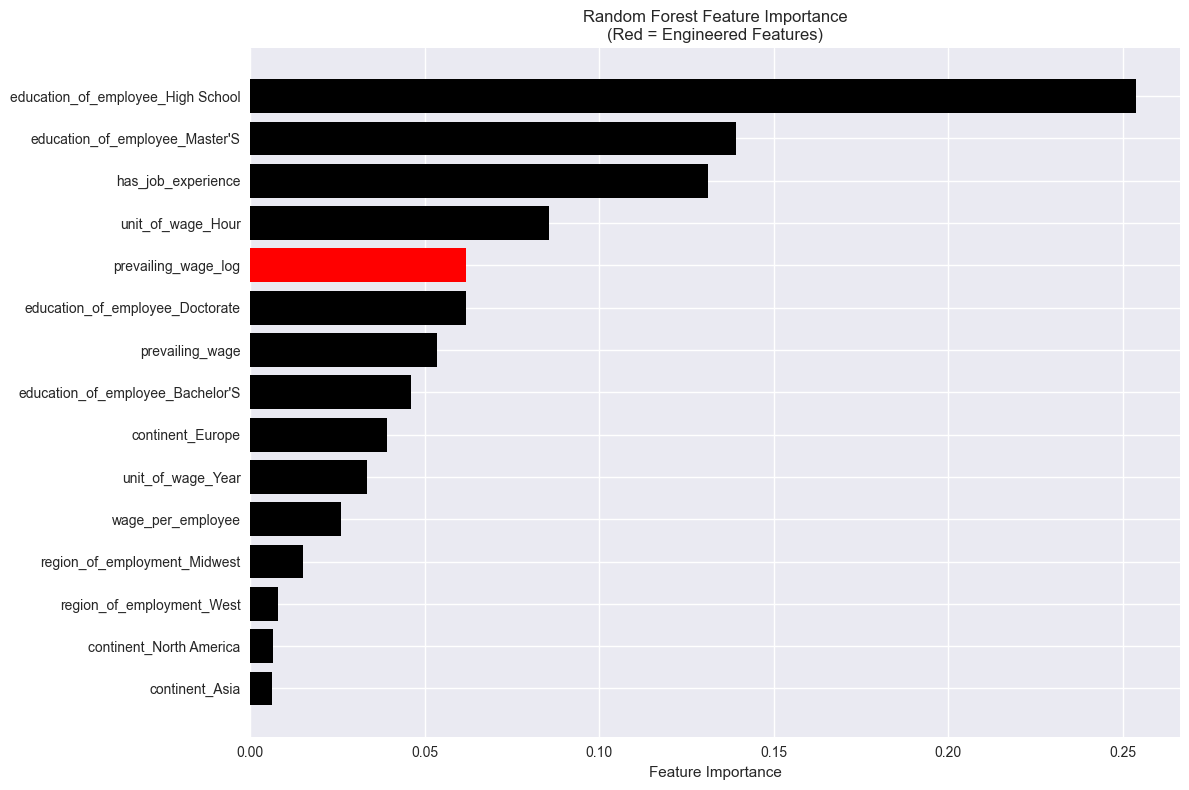

....Random Forest model completed...!


In [5]:
# Random Forest Classifier
print("RANDOM FOREST CLASSIFIER")
print("EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers")

# Create Random Forest model
# rf_model = RandomForestClassifier(
#     n_estimators=100,
#     random_state=42,
#     class_weight='balanced',  # Handle class imbalance
#     n_jobs=-1  # Use all available cores
# )

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,        # number of trees
    max_depth=5,             # limit tree depth
    min_samples_split=5,     # require more samples to split a node
    min_samples_leaf=4,      # require more samples at leaf nodes
    max_features='sqrt',     # limit number of features per split
    class_weight='balanced', # handle class imbalance
    random_state=42,
    n_jobs=-1                # Use all available cores
)


# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

train_balanced_acc_rf = balanced_accuracy_score(y_train, y_train_pred_rf)
val_balanced_acc_rf = balanced_accuracy_score(y_val, y_val_pred_rf)
test_balanced_acc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)

train_f1_rf = f1_score(y_train, y_train_pred_rf, average='macro')
val_f1_rf = f1_score(y_val, y_val_pred_rf, average='macro')
test_f1_rf = f1_score(y_test, y_test_pred_rf, average='macro')

print(f"\nRandom Forest Performance:")
print(f"Training - Accuracy: {train_accuracy_rf:.3f}, Balanced Acc: {train_balanced_acc_rf:.3f}, Macro F1: {train_f1_rf:.3f}")
print(f"Validation - Accuracy: {val_accuracy_rf:.3f}, Balanced Acc: {val_balanced_acc_rf:.3f}, Macro F1: {val_f1_rf:.3f}")
print(f"Test - Accuracy: {test_accuracy_rf:.3f}, Balanced Acc: {test_balanced_acc_rf:.3f}, Macro F1: {test_f1_rf:.3f}")

# Feature importance analysis
print(f"\nFeature Importance (Top 10):")
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'black' for f in top_features_rf['feature']]

plt.barh(range(len(top_features_rf)), top_features_rf['importance'], color=colors)
plt.yticks(range(len(top_features_rf)), top_features_rf['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Store Random Forest results
rf_results = {
    'model': 'Random Forest',
    'train_accuracy': train_accuracy_rf,
    'val_accuracy': val_accuracy_rf,
    'test_accuracy': test_accuracy_rf,
    'train_balanced_acc': train_balanced_acc_rf,
    'val_balanced_acc': val_balanced_acc_rf,
    'test_balanced_acc': test_balanced_acc_rf,
    'train_f1': train_f1_rf,
    'val_f1': val_f1_rf,
    'test_f1': test_f1_rf
}

print("....Random Forest model completed...!")


Step 4. XGBoost Classifier (ALSO EDA Recommendation)

In [6]:


print("LABEL ENCODING FOR XGBOOST COMPATIBILITY")
print("XGBoost requires class labels to start from 0, but wine quality starts from 3")

# Create label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit on all target data to ensure consistent encoding
all_y = pd.concat([y_train, y_val, y_test], ignore_index=True)
label_encoder.fit(all_y)

# Transform all target variables
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Original classes: {sorted(y_train.unique())}")
print(f"Encoded classes: {sorted(y_train_encoded)}")
print(f"Class mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Display encoded class distribution
print("\nEncoded class distribution:")
print("Training set:")
unique, counts = np.unique(y_train_encoded, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

print("Validation set:")
unique, counts = np.unique(y_val_encoded, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

print("Test set:")
unique, counts = np.unique(y_test_encoded, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

print("Label encoding completed!")


LABEL ENCODING FOR XGBOOST COMPATIBILITY
XGBoost requires class labels to start from 0, but wine quality starts from 3
Original classes: [np.int64(0), np.int64(1)]
Encoded classes: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0),

STEP 5  XGBoost Classifier

In [7]:
# XGBoost Classifier
print(".....XGBOOST CLASSIFIER....")
print("EDA recommendation: Best performance for structured data, handles non-linearity and feature interactions automatically")

if XGBOOST_AVAILABLE:
    # Create XGBoost model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        n_jobs=-1
    )
    
    # Train the model (using encoded labels for XGBoost)
    xgb_model.fit(X_train, y_train_encoded)
    
    # Make predictions
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_val_pred_xgb = xgb_model.predict(X_val)
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # Convert predictions back to original labels for evaluation
    y_train_pred_xgb_original = label_encoder.inverse_transform(y_train_pred_xgb)
    y_val_pred_xgb_original = label_encoder.inverse_transform(y_val_pred_xgb)
    y_test_pred_xgb_original = label_encoder.inverse_transform(y_test_pred_xgb)
    
    # Calculate metrics using original labels
    train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb_original)
    val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb_original)
    test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb_original)
    
    train_balanced_acc_xgb = balanced_accuracy_score(y_train, y_train_pred_xgb_original)
    val_balanced_acc_xgb = balanced_accuracy_score(y_val, y_val_pred_xgb_original)
    test_balanced_acc_xgb = balanced_accuracy_score(y_test, y_test_pred_xgb_original)
    
    train_f1_xgb = f1_score(y_train, y_train_pred_xgb_original, average='macro')
    val_f1_xgb = f1_score(y_val, y_val_pred_xgb_original, average='macro')
    test_f1_xgb = f1_score(y_test, y_test_pred_xgb_original, average='macro')
    
    print(f"\nXGBoost Performance:")
    print(f"Training - Accuracy: {train_accuracy_xgb:.3f}, Balanced Acc: {train_balanced_acc_xgb:.3f}, Macro F1: {train_f1_xgb:.3f}")
    print(f"Validation - Accuracy: {val_accuracy_xgb:.3f}, Balanced Acc: {val_balanced_acc_xgb:.3f}, Macro F1: {val_f1_xgb:.3f}")
    print(f"Test - Accuracy: {test_accuracy_xgb:.3f}, Balanced Acc: {test_balanced_acc_xgb:.3f}, Macro F1: {test_f1_xgb:.3f}")
    
    # Feature importance analysis
    print(f"\nFeature Importance (Top 10):")
    feature_importance_xgb = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    for i, (_, row) in enumerate(feature_importance_xgb.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")
    
    # Store XGBoost results
    xgb_results = {
        'model': 'XGBoost',
        'train_accuracy': train_accuracy_xgb,
        'val_accuracy': val_accuracy_xgb,
        'test_accuracy': test_accuracy_xgb,
        'train_balanced_acc': train_balanced_acc_xgb,
        'val_balanced_acc': val_balanced_acc_xgb,
        'test_balanced_acc': test_balanced_acc_xgb,
        'train_f1': train_f1_xgb,
        'val_f1': val_f1_xgb,
        'test_f1': test_f1_xgb
    }
    
    print("XGBoost model completed!")
    
else:
    print("... XGBoost not available. Skipping XGBoost model.")
    xgb_results = None


.....XGBOOST CLASSIFIER....
EDA recommendation: Best performance for structured data, handles non-linearity and feature interactions automatically

XGBoost Performance:
Training - Accuracy: 0.859, Balanced Acc: 0.817, Macro F1: 0.832
Validation - Accuracy: 0.735, Balanced Acc: 0.672, Macro F1: 0.681
Test - Accuracy: 0.716, Balanced Acc: 0.650, Macro F1: 0.657

Feature Importance (Top 10):
 1. education_of_employee_High School: 0.252
 2. unit_of_wage_Year: 0.212
 3. unit_of_wage_Hour: 0.082
 4. education_of_employee_Bachelor'S: 0.074
 5. has_job_experience: 0.073
 6. continent_Europe: 0.058
 7. region_of_employment_Midwest: 0.041
 8. education_of_employee_Doctorate: 0.024
 9. region_of_employment_South: 0.023
10. continent_North America: 0.020
XGBoost model completed!


STEP 6. NOW!! Model Comparison and Evaluation

MODEL COMPARISON AND EVALUATION

Model Performance Comparison:
Model           Train Acc  Val Acc    Test Acc   Val F1     Test F1   
Logistic Regression 0.714      0.710      0.695      0.687      0.671     
Random Forest   0.730      0.726      0.713      0.690      0.677     
XGBoost         0.859      0.735      0.716      0.681      0.657     

Best Model: Random Forest (Validation F1: 0.690)


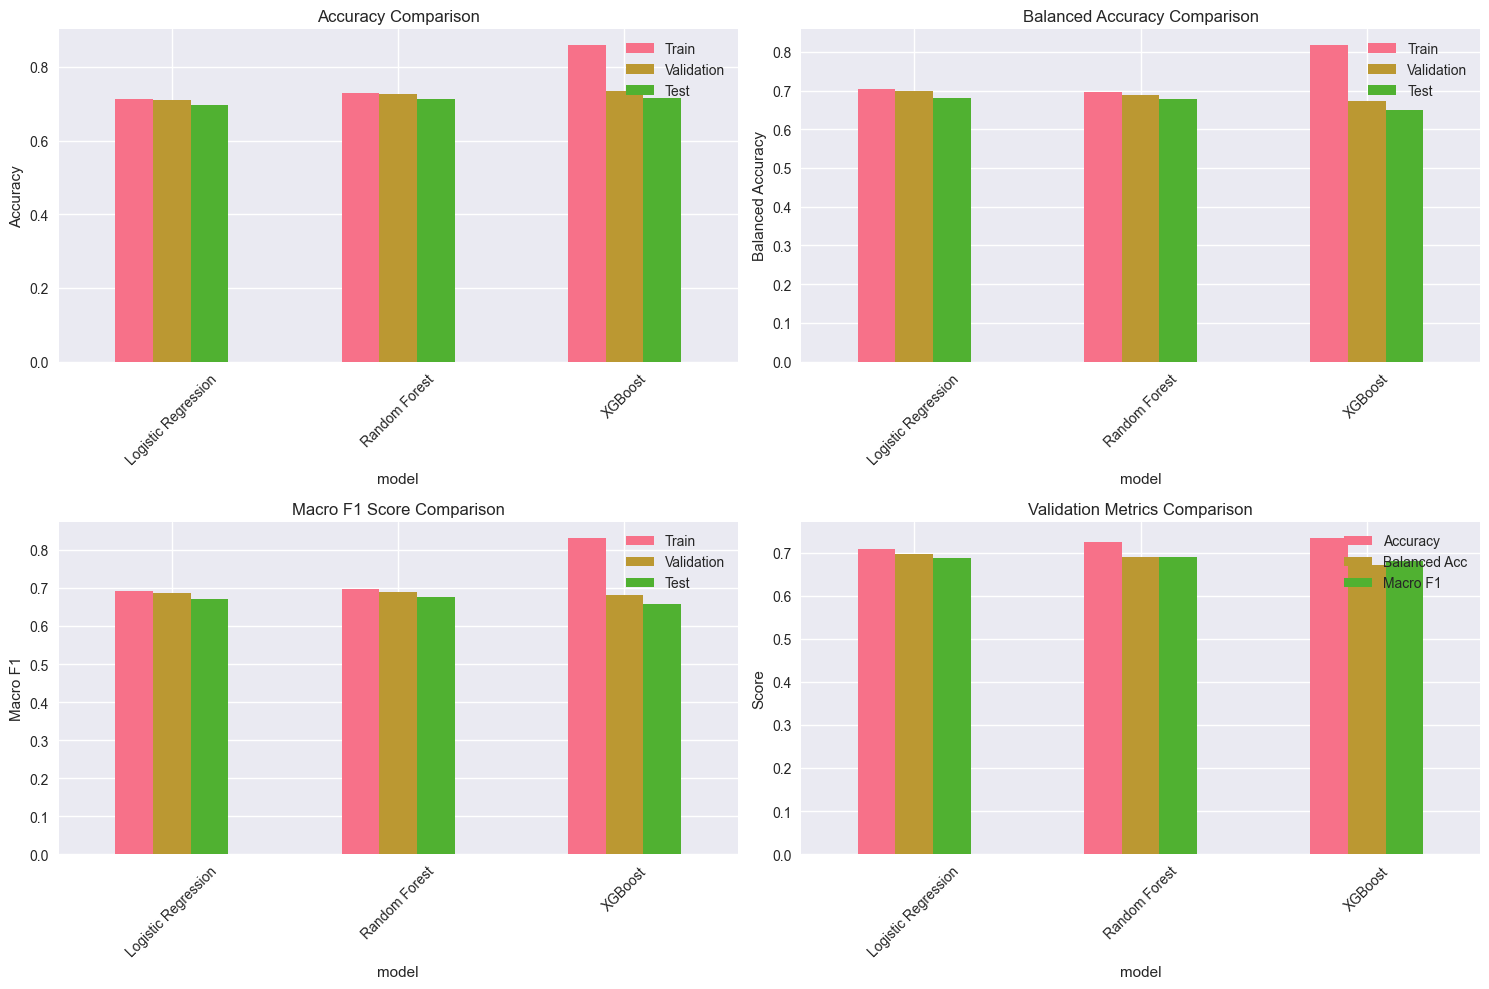

...Model comparison completed!


In [8]:

print("MODEL COMPARISON AND EVALUATION")

# Collect all results
all_results = [baseline_results, rf_results]
if xgb_results is not None:
    all_results.append(xgb_results)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.set_index('model')

print("\nModel Performance Comparison:")
print("=" * 80)
print(f"{'Model':<15} {'Train Acc':<10} {'Val Acc':<10} {'Test Acc':<10} {'Val F1':<10} {'Test F1':<10}")
print("=" * 80)
for _, row in comparison_df.iterrows():
    print(f"{row.name:<15} {row['train_accuracy']:<10.3f} {row['val_accuracy']:<10.3f} {row['test_accuracy']:<10.3f} {row['val_f1']:<10.3f} {row['test_f1']:<10.3f}")

# Find best model based on validation F1 score (EDA recommendation)
best_model_name = comparison_df['val_f1'].idxmax()
best_model_score = comparison_df.loc[best_model_name, 'val_f1']

print(f"\nBest Model: {best_model_name} (Validation F1: {best_model_score:.3f})")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy comparison
comparison_df[['train_accuracy', 'val_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(['Train', 'Validation', 'Test'])
axes[0,0].tick_params(axis='x', rotation=45)

# Balanced Accuracy comparison
comparison_df[['train_balanced_acc', 'val_balanced_acc', 'test_balanced_acc']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Balanced Accuracy Comparison')
axes[0,1].set_ylabel('Balanced Accuracy')
axes[0,1].legend(['Train', 'Validation', 'Test'])
axes[0,1].tick_params(axis='x', rotation=45)

# F1 Score comparison
comparison_df[['train_f1', 'val_f1', 'test_f1']].plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Macro F1 Score Comparison')
axes[1,0].set_ylabel('Macro F1')
axes[1,0].legend(['Train', 'Validation', 'Test'])
axes[1,0].tick_params(axis='x', rotation=45)

# Validation metrics only
validation_metrics = comparison_df[['val_accuracy', 'val_balanced_acc', 'val_f1']]
validation_metrics.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Validation Metrics Comparison')
axes[1,1].set_ylabel('Score')
axes[1,1].legend(['Accuracy', 'Balanced Acc', 'Macro F1'])
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("...Model comparison completed!")


STEP 7. Detailed Evaluation of Best Model

DETAILED EVALUATION OF BEST MODEL
Best Model: Random Forest
Validation F1 Score: 0.690

Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      1692
           1       0.79      0.78      0.78      3404

    accuracy                           0.71      5096
   macro avg       0.68      0.68      0.68      5096
weighted avg       0.71      0.71      0.71      5096


Confusion Matrix for Random Forest:
[[ 966  726]
 [ 737 2667]]


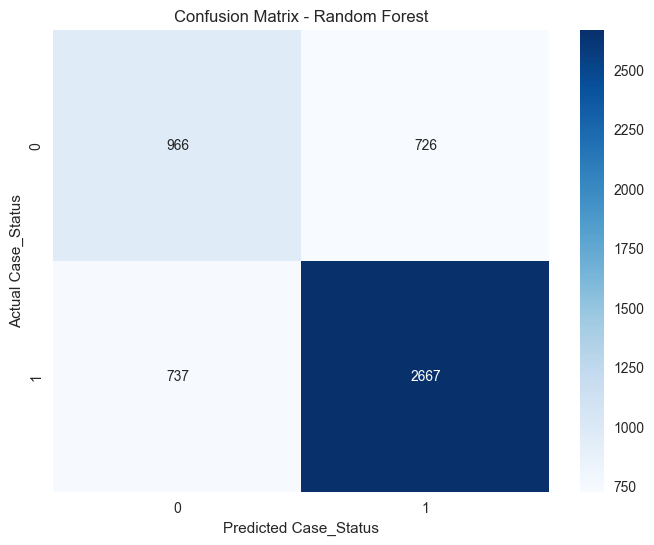


Per-class Performance for Random Forest:
case_Status 0: 0.571 accuracy (1692 samples)
case_Status 1: 0.783 accuracy (3404 samples)
...Detailed evaluation completed!


In [11]:
# Detailed evaluation of best model
print("DETAILED EVALUATION OF BEST MODEL")

# Get the best model
if best_model_name == 'Logistic Regression':
    best_model = baseline_model
    y_test_pred_best = y_test_pred
elif best_model_name == 'Random Forest':
    best_model = rf_model
    y_test_pred_best = y_test_pred_rf
elif best_model_name == 'XGBoost':
    best_model = xgb_model
    y_test_pred_best = y_test_pred_xgb

print(f"Best Model: {best_model_name}")
print(f"Validation F1 Score: {best_model_score:.3f}")

# Detailed classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, y_test_pred_best))

# Confusion matrix
print(f"\nConfusion Matrix for {best_model_name}:")
cm = confusion_matrix(y_test, y_test_pred_best)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Case_Status')
plt.ylabel('Actual Case_Status')
plt.show()

# Per-class performance
print(f"\nPer-class Performance for {best_model_name}:")
unique_classes = sorted(y_test.unique())
for class_label in unique_classes:
    class_mask = y_test == class_label
    if class_mask.sum() > 0:  # Only if class exists in test set
        class_accuracy = accuracy_score(y_test[class_mask], y_test_pred_best[class_mask])
        print(f"case_Status {class_label}: {class_accuracy:.3f} accuracy ({class_mask.sum()} samples)")

print("...Detailed evaluation completed!")


Interpretation for proper Understanding of the whole works done on the dataset...

True Negatives (TN) = 966
→ 966 rejected case were correctly predicted as rejected.

False Positives (FP) = 726
→ 726 rejected case were incorrectly approved.

False Negatives (FN) = 737
→ 737 approved Case were incorrectly rejected.

True Positives (TP) = 2667
→ 2667 approved loans were correctly predicted as approved

Step 8. Save Best Model and Results

In [12]:
# Save best model and results
print("SAVING BEST MODEL AND RESULTS ")

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print(f"- Best model ({best_model_name}) saved as 'best_model.pkl'")

# Save model comparison results
comparison_df.to_csv('model_comparison_results.csv')
print("- Model comparison results saved as 'model_comparison_results.csv'")

# Save detailed results
detailed_results = {
    'best_model': best_model_name,
    'best_model_score': best_model_score,
    'test_accuracy': comparison_df.loc[best_model_name, 'test_accuracy'],
    'test_balanced_acc': comparison_df.loc[best_model_name, 'test_balanced_acc'],
    'test_f1': comparison_df.loc[best_model_name, 'test_f1'],
    'confusion_matrix': cm.tolist(),
    'feature_importance': feature_importance_rf.to_dict('records') if best_model_name == 'Random Forest' else None
}

import json
with open('modeling_results.json', 'w') as f:
    json.dump(detailed_results, f, indent=2)
print("- Detailed results saved as 'modeling_results.json'")

# Save feature importance if available
if hasattr(best_model, 'feature_importances_'):
    feature_importance_best = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    feature_importance_best.to_csv('best_model_feature_importance.csv', index=False)
    print("- Best model feature importance saved as 'best_model_feature_importance.csv'")

print(f"\nMODELING SUMMARY")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {comparison_df.loc[best_model_name, 'test_accuracy']:.3f}")
print(f"Test Balanced Accuracy: {comparison_df.loc[best_model_name, 'test_balanced_acc']:.3f}")
print(f"Test Macro F1: {comparison_df.loc[best_model_name, 'test_f1']:.3f}")

print(f"\nFILES CREATED")
print("- best_model.pkl (trained model)")
print("- model_comparison_results.csv (performance comparison)")
print("- modeling_results.json (detailed results)")
if hasattr(best_model, 'feature_importances_'):
    print("- best_model_feature_importance.csv (feature importance)")

print(f"\nModeling phase completed successfully!")
print("... Ready for model deployment and production use")


SAVING BEST MODEL AND RESULTS 
- Best model (Random Forest) saved as 'best_model.pkl'
- Model comparison results saved as 'model_comparison_results.csv'
- Detailed results saved as 'modeling_results.json'
- Best model feature importance saved as 'best_model_feature_importance.csv'

MODELING SUMMARY
Best Model: Random Forest
Test Accuracy: 0.713
Test Balanced Accuracy: 0.677
Test Macro F1: 0.677

FILES CREATED
- best_model.pkl (trained model)
- model_comparison_results.csv (performance comparison)
- modeling_results.json (detailed results)
- best_model_feature_importance.csv (feature importance)

Modeling phase completed successfully!
... Ready for model deployment and production use
